<a href="https://colab.research.google.com/github/digital0923RJ/JAEYEON-JO-Momenta/blob/main/LCNN_Model_%3E_AUC_0_8165%2C_ACC_0_7363%2C_EER_0_2620.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is executed on an A100 GPU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ====================== Imports ======================
import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import hashlib

# ====================== Config ======================
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
REAL_PATH = Path("/content/drive/MyDrive/Internship /LJSpeech-1.1")
FAKE_PATH = Path("/content/drive/MyDrive/Internship /ljspeech_melgan_large")
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4
N_MELS = 40
DURATION = 5.0  # Audio duration fixed to 5 seconds

CACHE_DIR = Path("/content/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# ====================== Seed Setup ======================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

# ====================== Data Load ======================
real_paths = sorted(list(REAL_PATH.glob("**/*.[wW][aA][vV]")))
fake_paths = sorted(list(FAKE_PATH.glob("*.wav")))

file_paths = real_paths + fake_paths
labels = [0] * len(real_paths) + [1] * len(fake_paths)

file_paths = list(file_paths)
labels = list(labels)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# ====================== SpecAverage  ======================
def spec_average_augment(spec, time_mask_width=10, freq_mask_width=5):
    spec = spec.copy()
    mean_val = np.mean(spec)
    t = spec.shape[1]
    if t > time_mask_width:
        t_start = np.random.randint(0, t - time_mask_width)
        spec[:, t_start:t_start + time_mask_width] = mean_val
    f = spec.shape[0]
    if f > freq_mask_width:
        f_start = np.random.randint(0, f - freq_mask_width)
        spec[f_start:f_start + freq_mask_width, :] = mean_val
    return spec

def extract_logmel(path, sr=16000, n_mels=N_MELS, duration=DURATION, cache_dir=CACHE_DIR):
    target_length = int(sr * duration)
    cache_file = cache_dir / (hashlib.md5(str(path).encode()).hexdigest() + ".npy")
    if cache_file.exists():
        log_mel_aug = np.load(cache_file)
    else:
        y, _ = librosa.load(path, sr=sr)
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        log_mel = librosa.power_to_db(mel)
        log_mel_aug = spec_average_augment(log_mel)
        np.save(cache_file, log_mel_aug)
    return torch.tensor(log_mel_aug).float()

class LogMelDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        feature = extract_logmel(self.file_paths[idx])
        feature = feature.unsqueeze(0)
        label = torch.tensor(self.labels[idx]).float()
        return feature, label

def pad_collate_fn(batch):
    features, labels = zip(*batch)
    max_len = max([f.shape[-1] for f in features])
    padded = [torch.nn.functional.pad(f, (0, max_len - f.shape[-1])) for f in features]
    return torch.stack(padded), torch.tensor(labels).float()

train_set = LogMelDataset(train_paths, train_labels)
test_set = LogMelDataset(test_paths, test_labels)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=pad_collate_fn, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                         collate_fn=pad_collate_fn, num_workers=4, pin_memory=True)

In [4]:
# ====================== MFM Layer ======================
class MFM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * 2, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels * 2)

    def forward(self, x):
        x = self.bn(self.conv(x))
        out = torch.chunk(x, 2, dim=1)
        return torch.max(out[0], out[1])

# ====================== LCNN with MFM ======================
class LCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            MFM(1, 16),
            MFM(16, 32),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(self.conv(x))

In [5]:

# ====================== Training & Evaluation ======================
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE).unsqueeze(1)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            pred = model(x)
            preds.extend(pred.cpu().numpy())
            targets.extend(y.numpy())
    preds = np.array(preds).flatten()
    targets = np.array(targets)
    auc = roc_auc_score(targets, preds)
    acc = accuracy_score(targets, (preds > 0.5).astype(int))
    fpr, tpr, _ = roc_curve(targets, preds)
    eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    return auc, acc, eer, preds, targets

def run_model(model_class, name):
    print(f"\n▶ Training {name}...")
    model = model_class().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCELoss()
    history = {'auc': [], 'acc': [], 'eer': []}
    for epoch in range(EPOCHS):
        loss = train(model, train_loader, optimizer, criterion)
        auc, acc, eer, _, _ = evaluate(model, test_loader)
        history['auc'].append(auc)
        history['acc'].append(acc)
        history['eer'].append(eer)
        print(f"{name} Epoch {epoch+1}: Loss={loss:.4f}, AUC={auc:.4f}, ACC={acc:.4f}, EER={eer:.4f}")
    return model, history

lcnn_model, lcnn_history = run_model(LCNN, "LCNN")



▶ Training LCNN...
LCNN Epoch 1: Loss=0.6904, AUC=0.5826, ACC=0.5570, EER=0.4416
LCNN Epoch 2: Loss=0.6865, AUC=0.5958, ACC=0.5788, EER=0.4214
LCNN Epoch 3: Loss=0.6828, AUC=0.6238, ACC=0.5528, EER=0.4077
LCNN Epoch 4: Loss=0.6793, AUC=0.6470, ACC=0.5959, EER=0.3883
LCNN Epoch 5: Loss=0.6754, AUC=0.6617, ACC=0.5833, EER=0.3802
LCNN Epoch 6: Loss=0.6714, AUC=0.6655, ACC=0.6255, EER=0.3719
LCNN Epoch 7: Loss=0.6680, AUC=0.6914, ACC=0.6407, EER=0.3574
LCNN Epoch 8: Loss=0.6623, AUC=0.6620, ACC=0.6203, EER=0.3734
LCNN Epoch 9: Loss=0.6584, AUC=0.6784, ACC=0.6322, EER=0.3593
LCNN Epoch 10: Loss=0.6537, AUC=0.7151, ACC=0.6615, EER=0.3368
LCNN Epoch 11: Loss=0.6492, AUC=0.6897, ACC=0.6552, EER=0.3509
LCNN Epoch 12: Loss=0.6445, AUC=0.7452, ACC=0.5368, EER=0.3139
LCNN Epoch 13: Loss=0.6390, AUC=0.7269, ACC=0.6493, EER=0.3272
LCNN Epoch 14: Loss=0.6355, AUC=0.7643, ACC=0.6651, EER=0.3043
LCNN Epoch 15: Loss=0.6297, AUC=0.7164, ACC=0.5681, EER=0.3333
LCNN Epoch 16: Loss=0.6251, AUC=0.7601, ACC=

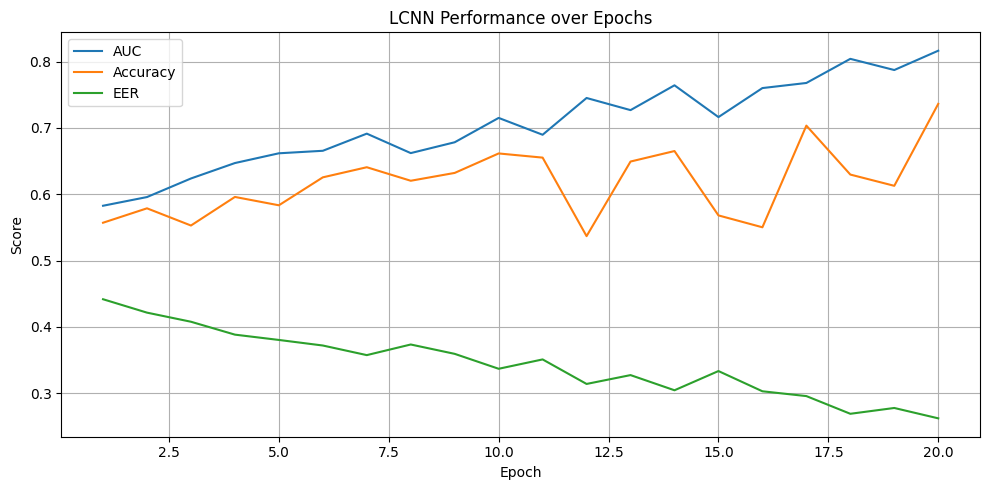

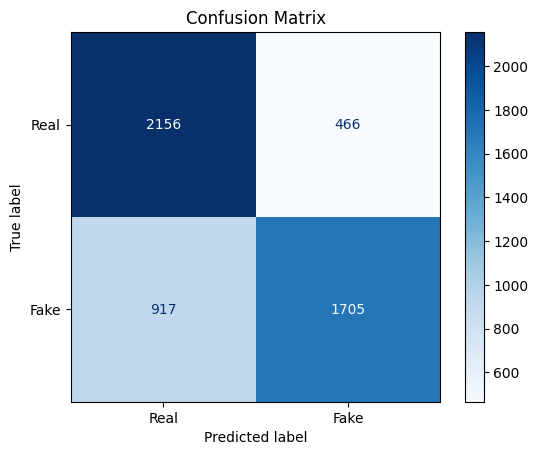


🎯 Final Results
LCNN -> AUC: 0.8165, ACC: 0.7363, EER: 0.2620


In [10]:
# ====================== Visualization ======================
epochs = list(range(1, EPOCHS + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, lcnn_history['auc'], label='AUC')
plt.plot(epochs, lcnn_history['acc'], label='Accuracy')
plt.plot(epochs, lcnn_history['eer'], label='EER')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("LCNN Performance over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lcnn_epoch_performance.png")
plt.show()

# Confusion Matrix
_, _, _, preds, targets = evaluate(lcnn_model, test_loader)
preds_binary = (np.array(preds) > 0.5).astype(int)
cm = confusion_matrix(targets, preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print("\n🎯 Final Results")
print(f"LCNN -> AUC: {lcnn_history['auc'][-1]:.4f}, ACC: {lcnn_history['acc'][-1]:.4f}, EER: {lcnn_history['eer'][-1]:.4f}")
